In [2]:
!pip install pygeohash

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pygeohash as gh
%matplotlib inline

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import ensemble
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score

In [5]:
df = pd.read_csv('data.csv')

/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


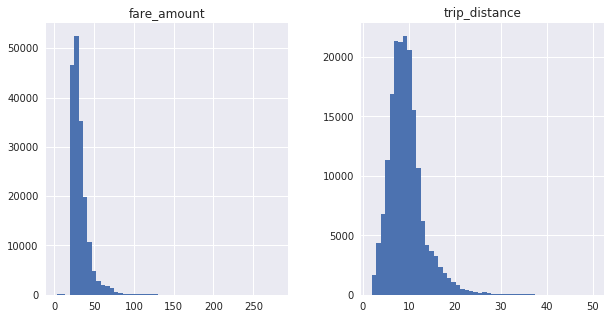

In [6]:
# Remove those rows with very low or very high fare_amount or trip_distance
df_filtered = df[(df['trip_distance'] >= 2) & (df['trip_distance'] <= 50) & (df['fare_amount'] >= 3) & (df['fare_amount'] <=300)]
df_filtered[['trip_distance','fare_amount']].hist(figsize = (10,5), bins=50);

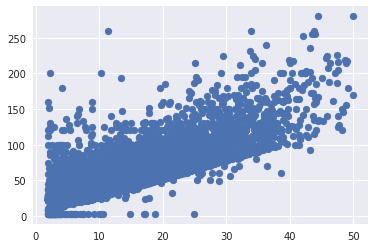

In [7]:
plt.scatter(df_filtered['trip_distance'], df_filtered['fare_amount']);

/usr/local/envs/py2env/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


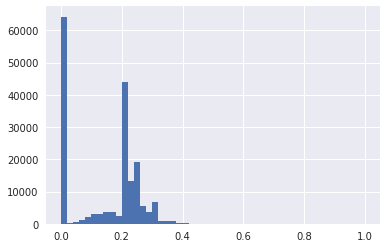

In [8]:
df_filtered['tip_pct'] = df_filtered['tip_amount']/df_filtered['fare_amount']
df_filtered = df_filtered[df_filtered['tip_pct'] <= 1]
df_filtered['tip_pct'].hist(bins=50);

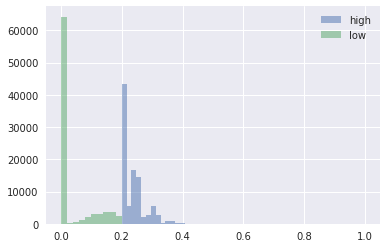

In [9]:
df_filtered['tip_class'] = np.where(df_filtered['tip_pct']>=0.2, 'high', 'low')
labels = ['high', 'low']
plt.hist(df_filtered['tip_pct'].loc[df_filtered['tip_class'] == 'high'], bins=50, alpha=0.5, label='high')
plt.hist(df_filtered['tip_pct'].loc[df_filtered['tip_class'] == 'low'], bins=10, alpha=0.5, label='low')
plt.legend(loc='upper right')
plt.show()

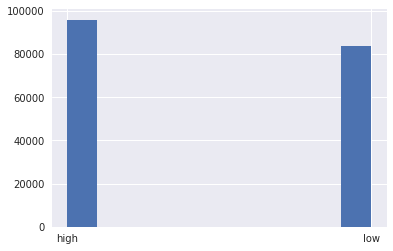

In [10]:
df_filtered['tip_class'].hist();

In [11]:
df_filtered['pickup_datetime'] = pd.to_datetime(df_filtered['pickup_datetime'])
df_filtered['dropoff_datetime'] = pd.to_datetime(df_filtered['dropoff_datetime'])
df_filtered['trip_duration'] = (df_filtered['dropoff_datetime']-df_filtered['pickup_datetime']).dt.total_seconds()/60
df_filtered['year'] = df_filtered['pickup_datetime'].dt.year
df_filtered['day'] = df_filtered['pickup_datetime'].dt.day
df_filtered['month'] = df_filtered['pickup_datetime'].dt.month
df_filtered['day_of_week'] = df_filtered['pickup_datetime'].dt.weekday_name
df_filtered['hour_of_day'] = df_filtered['pickup_datetime'].dt.hour
df_filtered['lat_dif'] = df_filtered['pickup_latitude'] - df_filtered['dropoff_latitude']
df_filtered['lon_dif'] = df_filtered['pickup_longitude'] - df_filtered['dropoff_longitude']
df_filtered['pickup_geohash']=df_filtered.apply(lambda x: gh.encode(x.pickup_latitude, x.pickup_longitude, precision=5), axis=1)
df_filtered['dropoff_geohash']=df_filtered.apply(lambda x: gh.encode(x.dropoff_latitude, x.dropoff_longitude, precision=5), axis=1)

df_filtered.head()

,Unnamed: 0,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,...,trip_duration,year,day,month,day_of_week,hour_of_day,lat_dif,lon_dif,pickup_geohash,dropoff_geohash
0,0,2,2015-07-18 11:25:58,2015-07-18 11:43:47,1,7.21,-73.862762,40.769028,1.0,N,...,17.816667,2015,18,7,Saturday,11,0.046444,0.086441,dr5rz,dr5rt
1,1,1,2015-03-15 12:50:01,2015-03-15 13:23:35,1,10.80,-73.870926,40.773727,NaN,N,...,33.566667,2015,15,3,Sunday,12,0.008034,0.117302,dr5rz,dr5ru
2,2,2,2015-04-30 12:25:44,2015-04-30 13:03:51,1,4.28,-73.978180,40.762341,NaN,N,...,38.116667,2015,30,4,Thursday,12,0.051552,0.030731,dr5ru,dr5re
3,3,2,2015-05-28 08:47:56,2015-05-28 09:26:08,1,18.47,-73.776711,40.645302,NaN,N,...,38.200000,2015,28,5,Thursday,8,-0.207550,0.066711,dr5x1,dr72r
4,4,1,2015-06-20 19:36:17,2015-06-20 20:10:49,1,15.50,-73.777054,40.644947,NaN,Y,...,34.533333,2015,20,6,Saturday,19,-0.080074,0.169746,dr5x1,dr5rt


In [12]:
df_filtered.shape

(179682, 32)

In [13]:
df_filtered = df_filtered[df_filtered['lat_dif'].notnull() & df_filtered['lon_dif'].notnull()]
df_filtered.shape

(135875, 32)

In [15]:
def train_test_split(X, y):
    X_train = X.loc[X['year'] == 2015].drop('year', axis=1)
    y_train = y.loc[y['year'] == 2015].drop('year', axis=1).values.ravel()
    X_test = X.loc[X['year'] == 2016].drop('year', axis=1)
    y_test = y.loc[y['year'] == 2016].drop('year', axis=1).values.ravel()
    return X_train, y_train, X_test, y_test

def model_results(X_train, y_train, X_test, y_test, model):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_train = [1 if x == 'high' else 0 for x in y_train]
    y_test = [1 if x == 'high' else 0 for x in y_test]
    y_train_pred = [1 if x == 'high' else 0 for x in y_train_pred]
    y_test_pred = [1 if x == 'high' else 0 for x in y_test_pred]
    print("----Training Data results (2015 data set)----")
    print("Accuracy: {:.2f}".format(accuracy_score(y_train,y_train_pred)))
    print("AUC: {:.2f}".format(roc_auc_score(y_train,y_train_pred)))
    print("Precision: {}".format(precision_score(y_train,y_train_pred)))
    print("Recall: {}\n".format(recall_score(y_train,y_train_pred)))
    
    print("----Test Data results (2016 data set)----")
    print("Accuracy: {:.2f}".format(accuracy_score(y_test,y_test_pred)))
    print("AUC: {:.2f}".format(roc_auc_score(y_test,y_test_pred)))
    print("Precision: {}".format(precision_score(y_test,y_test_pred)))
    print("Recall: {}\n".format(recall_score(y_test,y_test_pred)))

In [28]:
y = df_filtered[['tip_class', 'year']]
X = df_filtered[['passenger_count', 'trip_distance', 'fare_amount', 'trip_duration', 'year', 'month', 'day_of_week', 'hour_of_day', 'lat_dif', 'lon_dif', 'pickup_geohash']]
X_encoded = pd.get_dummies(X, columns=['month', 'day_of_week', 'hour_of_day', 'pickup_geohash'])

In [29]:
X_train, y_train, X_test, y_test = train_test_split(X_encoded, y)

In [30]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2, 'learning_rate': 0.01, 'loss': 'deviance'}
gbc = ensemble.GradientBoostingClassifier(**params)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [31]:
model_results(X_train, y_train, X_test, y_test, gbc)

----Training Data results (2015 data set)----
Accuracy: 0.60
AUC: 0.60
Precision: 0.611054224913
Recall: 0.604181798173

----Test Data results (2016 data set)----
Accuracy: 0.59
AUC: 0.59
Precision: 0.658448485867
Recall: 0.593960748655



In [21]:
weather_df = pd.read_csv('weather_data.csv')
weather_df.head()

,Unnamed: 0,year,month,day,min_temp,max_temp,prcp,sndp
0,0,2016,4,3,35.1,61.0,0.24,999.9
1,1,2016,3,21,33.1,50.0,0.14,999.9
2,2,2016,8,5,70.0,86.0,0.00,999.9
3,3,2016,10,31,46.9,60.1,0.76,999.9
4,4,2016,3,25,44.1,73.0,0.00,999.9


In [22]:
df_augmented = df_filtered.merge(weather_df, how='inner', on = ['year', 'month', 'day'])
print(df_augmented.shape)
df_augmented.head()

(135875, 37)


,Unnamed: 0_x,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,...,hour_of_day,lat_dif,lon_dif,pickup_geohash,dropoff_geohash,Unnamed: 0_y,min_temp,max_temp,prcp,sndp
0,0,2,2015-07-18 11:25:58,2015-07-18 11:43:47,1,7.21,-73.862762,40.769028,1.0,N,...,11,0.046444,0.086441,dr5rz,dr5rt,696,68.0,86.0,0.0,999.9
1,1015,1,2015-07-18 05:45:28,2015-07-18 06:10:13,1,14.00,-74.011505,40.702785,1.0,N,...,5,0.103264,0.077049,dr5re,dr5qf,696,68.0,86.0,0.0,999.9
2,1425,1,2015-07-18 00:22:24,2015-07-18 00:50:07,1,6.10,-74.008011,40.741375,1.0,N,...,0,-0.062584,-0.044930,dr5rg,dr72h,696,68.0,86.0,0.0,999.9
3,3924,1,2015-07-18 21:58:53,2015-07-18 22:16:51,1,7.50,-73.970001,40.785599,1.0,N,...,21,-0.071918,-0.036736,dr72h,dr72m,696,68.0,86.0,0.0,999.9
4,4093,1,2015-07-18 11:19:37,2015-07-18 11:46:54,2,10.00,-73.862732,40.769016,1.0,N,...,11,0.047882,0.124977,dr5rz,dr5rs,696,68.0,86.0,0.0,999.9


In [32]:
y = df_augmented[['tip_class', 'year']]
X = df_augmented[['passenger_count', 'trip_distance', 'fare_amount', 'trip_duration', 'year', 'month', 'day_of_week', 'hour_of_day', 'lat_dif', 'lon_dif', 'pickup_geohash',\
                 'min_temp', 'max_temp', 'prcp', 'sndp']]
X_encoded = pd.get_dummies(X, columns=['month', 'day_of_week', 'hour_of_day', 'pickup_geohash'])
X_train_aug, y_train_aug, X_test_aug, y_test_aug = train_test_split(X_encoded, y)

In [33]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2, 'learning_rate': 0.01, 'loss': 'deviance'}
gbc_aug = ensemble.GradientBoostingClassifier(**params)
gbc_aug.fit(X_train_aug, y_train_aug)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [34]:
model_results(X_train_aug, y_train_aug, X_test_aug, y_test_aug, gbc_aug)

----Training Data results (2015 data set)----
Accuracy: 0.60
AUC: 0.60
Precision: 0.610316331971
Recall: 0.604688015847

----Test Data results (2016 data set)----
Accuracy: 0.59
AUC: 0.59
Precision: 0.658386394102
Recall: 0.595476244601



In [35]:
def importances(X_train, model):
    # Plot feature importance
    feature_importance = model.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[::-1][:20][::-1]
    names = [X_train.columns[index] for index in sorted_idx]
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure(figsize=(10,10))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, names)
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.tight_layout()
    plt.show()

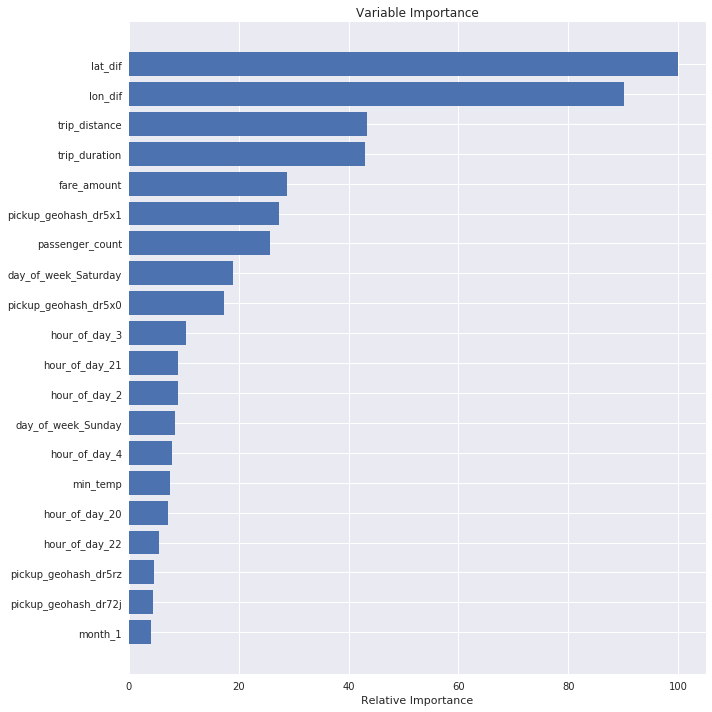

In [36]:
importances(X_train_aug, gbc_aug)